# Introduction to PHYRE

PHYRE consists of an environment, a two-dimensional world with Newtonian physics, and a set of tasks.
Each task consists of an initial scene with some geometric bodies and a goal condition that should be satisified.
An agent can introduce one or two extra objects into a scene. Once done, the agent request of sumulation of scene.
The task is considered to be **solved**, if after the simulation the goal condition is satisfied.

The image below shows three different tasks (on the left) and result of simulation with a ball introduced into the scene. Note that in the current version of the dataset all tasks have the same goal: a pair of colored object (blue, green, or purple) should touch each other.


This notebook shows how to use the ```phyre``` API to interact with the environment and tasks and how to train a simple random agent.

![PHYRE tasks](../imgs/task_example.png "PHYRE tasks and simulation example")



### Run this in colab
You can open and play with this notebook in colab. 
<a href="https://colab.research.google.com/github/facebookresearch/phyre/blob/master/examples/01_phyre_intro.ipynb" target="_parent">Open In Colab</a>

In [ ]:
# Install phyre and auxiliary packages.
!pip install phyre matplotlib tqdm ipywidgets

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

import phyre
random.seed(0)

# Part 1: Introduction to PHYRE simulator


As described in the [PHYRE paper](https://arxiv.org/abs/1908.05656), the dataset consists consists of two groups of tasks referred to as **tiers**.
Currently we have two tiers: `ball` and `two_balls`. Tasks in the former tier are guaranteed to be solvable with a single ball, i.e., a goal condition could be satisfied at the end of simulation if a ball of right size is introduced at a right location. Naturally, tasks in the latter tier require two balls.

Within each tier tasks are grouped in **task templates**. Each template consists of 100 conceptually similar modifications. The image below shows some examples of tasks from different templates and from the same template.

![PHYRE tasks](../imgs/cross_within.png "PHYRE tasks and templates")


## Eval setups

We can measure two types of generalization: within template and cross template.
This could be done for both tiers resulting in four **eval setups**.
Each eval setup defines which tasks to use for training, validation and testing. One can access the list of eval setups using `phyre.MAIN_EVAL_SETUPS`.

In [2]:
print('All eval setups:', *phyre.MAIN_EVAL_SETUPS)
# For now, let's select cross template for ball tier.
eval_setup = 'ball_cross_template'

All eval setups: ball_cross_template ball_within_template two_balls_cross_template two_balls_within_template


For any type of generalization we can build multiple splits intro train, dev, and test. Moreover, different splits will have different complexity. Due to that reason we recommend to use 10 folds to report results (see paper for details). Here, we will a single fold.

In [8]:
fold_id = 2 # For simplicity, we will just use one fold for evaluation.
train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
print('Size of resulting splits:\n train:', len(train_tasks), '\n dev:',
      len(dev_tasks), '\n test:', len(test_tasks))

Size of resulting splits:
 train: 1600 
 dev: 400 
 test: 500


Each split contains a tuple of tasks in the format ```TEMPLATE_ID:INSTANCE_ID```. Let's look into some dev tasks for example:

In [9]:
print(*test_tasks[:10], sep=', ')

00002:007, 00002:011, 00002:015, 00002:017, 00002:023, 00002:026, 00002:028, 00002:029, 00002:031, 00002:041


We can see a task instance using a player, e.g., http://player.phyre.ai/#/task/00110:007

Also, you can run a server locally using `phyre -m phyre.server`.

## Action simulator

In a nutshell, ActionSimulator does two things:

  * Returns observations for a task.
  * Runs a simulation for a task and an action.

Action space depends on the eval setup as we have different degrees of freedom for a single ball vs two balls. Therefore, we define two action tiers that define the set of allowed action and their mapping to scene objects.
Naturally, name of the action tier matches the name of the task tier. To get it from eval setup name, use `phyre.eval_setup_to_action_space`.

In [10]:
action_tier = phyre.eval_setup_to_action_tier(eval_setup)
print('Action tier for', eval_setup, 'is', action_tier)

Action tier for ball_cross_template is ball


With an action tier and a set of tasks, we can build a simulator using `phyre.initialize_simulator`. For simplicity, we'll use the first 50 items from the dev split.

In [12]:
tasks = test_tasks[:50]

# Create the simulator from the tasks and tier.
simulator = phyre.initialize_simulator(tasks, action_tier)

#### Observations

Given a simulator one can get access to the observations, e.g., the initial scene. Each observation a 2d integer array of size `phyre.SCENE_HEIGHT X phyre.SCENE_WIDTH`, i.e., `256x256`. Different values correspond to different object roles, e.g., background, default static object, static objects involved in goal condition, etc. The mapping is not a part of the public interface as we assume that the agents will learn the coding naturally. Alternatively, we provide `phyre.observations_to_float_rgb` function to map observations into RGB image.

50
Initial scene shape=(256, 256) dtype=int64


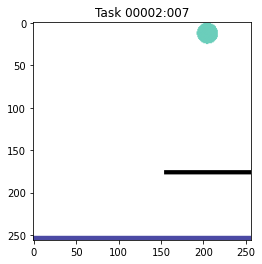

In [13]:
task_index = 0  # Note, this is a integer index of task within simulator.task_ids.
task_id = simulator.task_ids[task_index]
print(len(simulator.task_ids))
initial_scene = simulator.initial_scenes[task_index]
print('Initial scene shape=%s dtype=%s' % (initial_scene.shape, initial_scene.dtype))
plt.imshow(phyre.observations_to_float_rgb(initial_scene))
plt.title(f'Task {task_id}');

#### Initial vectorized objects

In addition to the pixelized initial scenes, one can also get access to a vectorized state of each scene object in it's initial posiition. Each task is represented as a FeaturizedObjects, which contains features represented as a 1 x (NUM_SCENE_OBJECTS + TASK_TIER_NUM_USER_INPUTS) x 14 np.ndarray. The features of the object, in order are:


  0. x in pixels of center of mass divided by SCENE_WIDTH
  1. y in pixels of center of mass divided by SCENE_HEIGHT
  2. angle of the object between 0 and 2pi divided by 2pi
  3. diameter in pixels of object divided by SCENE_WIDTH
  4. \- 8. One hot encoding of the object shape, according to order: ball, bar, jar, standing sticks
  8. \- 14. One hot encoding of object color, according to order: red, green, blue, purple, gray, black
  
As the scene is vectorized into prior to user input, the rows represent only scene objects.

In [14]:
# Let's see the features of the initial featurized objects for the scene visualized above
initial_featurized_objects = simulator.initial_featurized_objects[task_index]
print('Initial featurized objects shape=%s dtype=%s' % (initial_featurized_objects.features.shape, initial_featurized_objects.features.dtype))
np.set_printoptions(precision=3)
print(initial_featurized_objects.features)

Initial featurized objects shape=(1, 3, 14) dtype=float32
[[[0.8   0.31  0.    0.4   0.    1.    0.    0.    0.    0.    0.
   0.    0.    1.   ]
  [0.8   0.949 0.    0.098 1.    0.    0.    0.    0.    1.    0.
   0.    0.    0.   ]
  [0.5   0.01  0.    1.    0.    1.    0.    0.    0.    0.    0.
   1.    0.    0.   ]]]


#### Simulation

The action space is always a unit cube, but the dimension depends on the action tier. For the ball tier, the dimensionality of the action space is 3, corresponding to the (x,y) position of the ball and its radius r. For two ball tiers the dimension is 6.

In [15]:
print('Dimension of the action space:', simulator.action_space_dim)

Dimension of the action space: 3


We can also use the simulator to sample a fixed set of random actions from the action space using `build_discrete_action_space`. The function samples actions uniformly from the action cube skipping invalid ones. The set is guaranteed to be deterministic.

In [16]:
actions = simulator.build_discrete_action_space(max_actions=100)
print('A random action:', actions[0])

A random action: [4.170e-01 7.203e-01 1.144e-04]


Now that we have an action, we can use the simulator to simulate it. Let's simulate it on the first task instance in our dataset. The simulator returns a Simulation object containing, **status** of the simulation (`phyre.SimulationStatus`), intermediate observations, and information about the object states in a FeaturizedObjects object.

In [17]:
task_index = 0  # The simulator takes an index into simulator.task_ids.
action = random.choice(actions)
# Set need_images=False and need_featurized_objects=False to speed up simulation, when only statuses are needed.
simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True)

The first peice of information stored in the `simulation` is the status of the simulation.

In [18]:
# Three statuses could be returned.
print('Action solves task:', phyre.SimulationStatus.SOLVED)
print('Action does not solve task:', phyre.SimulationStatus.NOT_SOLVED)
print('Action is an invalid input on task (e.g., occludes a task object):',
      phyre.SimulationStatus.INVALID_INPUT)
# May call is_* methods on the status to check the status.
print()
print('Result of taking action', action, 'on task', tasks[task_index], 'is:',
      simulation.status)
print('Does', action, 'solve task', tasks[task_index], '?', simulation.status.is_solved())
print('Is', action, 'an invalid action on task', tasks[task_index], '?',
      simulation.status.is_invalid())

Action solves task: SimulationStatus.SOLVED
Action does not solve task: SimulationStatus.NOT_SOLVED
Action is an invalid input on task (e.g., occludes a task object): SimulationStatus.INVALID_INPUT

Result of taking action [0.39  0.486 0.604] on task 00002:007 is: SimulationStatus.NOT_SOLVED
Does [0.39  0.486 0.604] solve task 00002:007 ? False
Is [0.39  0.486 0.604] an invalid action on task 00002:007 ? False


The simulator also returns a series of observations from the simulation at different timesteps. The observations are taken every second during the simulation.

Number of observations returned by simulator: 17


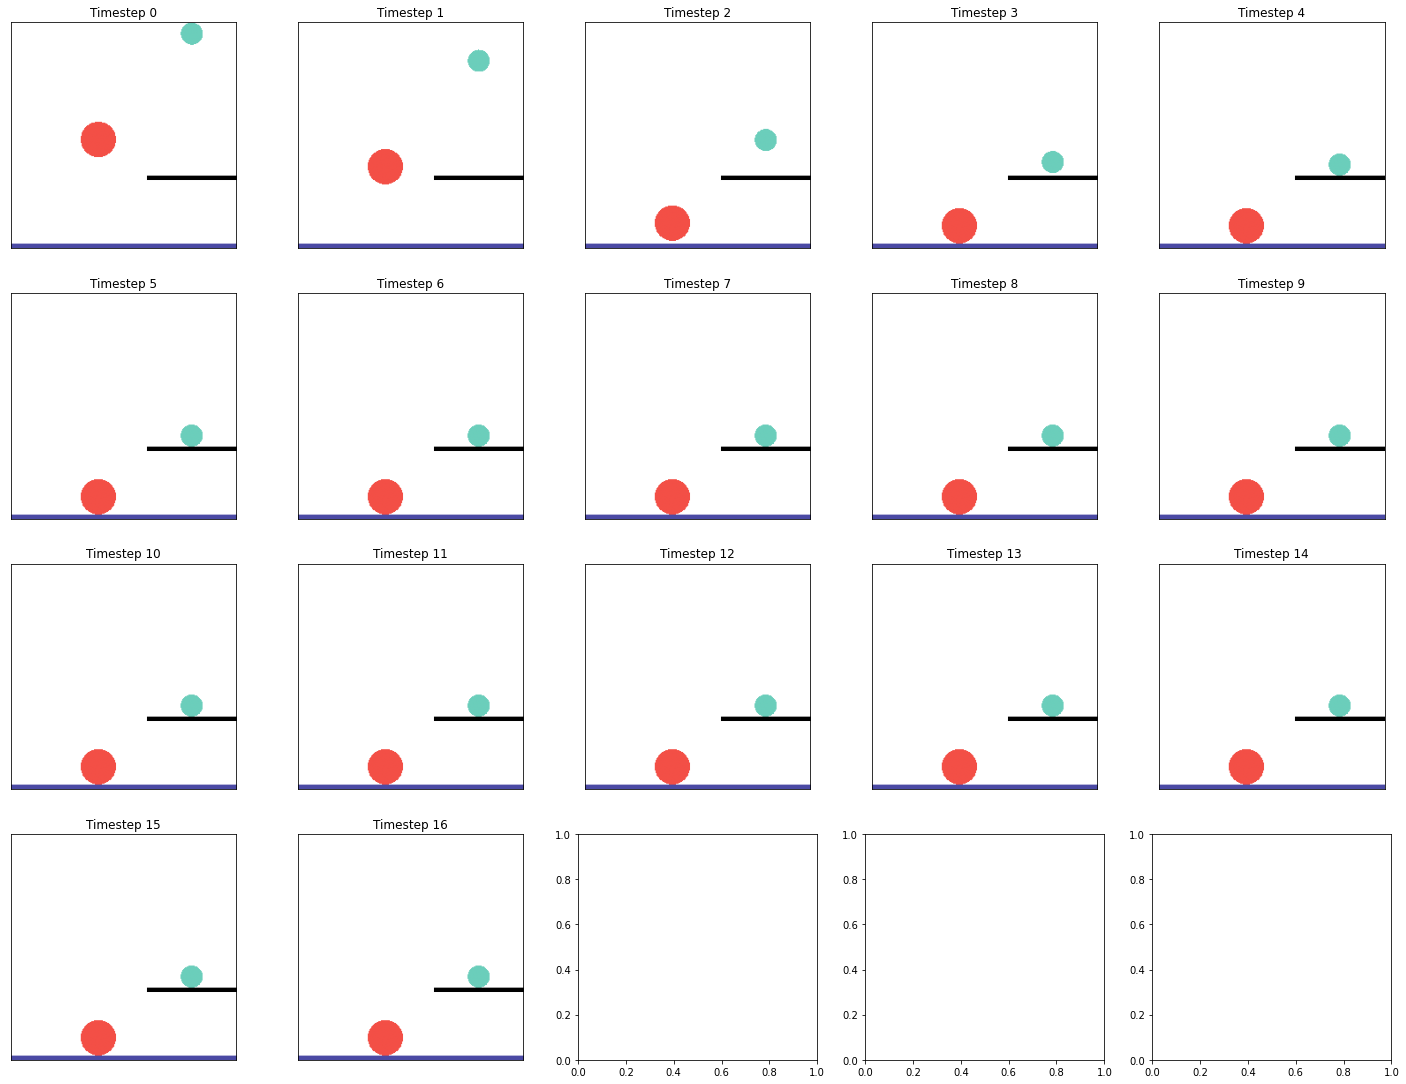

In [19]:
%matplotlib inline
print('Number of observations returned by simulator:', len(simulation.images))

num_across = 5
height = int(math.ceil(len(simulation.images) / num_across))
fig, axs = plt.subplots(height, num_across, figsize=(20, 15))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# We can visualize the simulation at each timestep.
for i, (ax, image) in enumerate(zip(axs.flatten(), simulation.images)):
    # Convert the simulation observation to images.
    img = phyre.observations_to_float_rgb(image)
    ax.imshow(img)
    ax.title.set_text(f'Timestep {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

The simulation also contains information about the objects in the scene, including the user inputs, and their states.

The state of an object at a specific timestep is it's x position normlaized by `SCENE_WIDTH`, it's y positiion normalized by `SCENE_HEIGHT` and its angle between 0...2pi normalized by 2pi.

In [22]:
featurized_objects = simulation.featurized_objects
print('Number of total objects in the simulation:', featurized_objects.num_objects)
print('Number of scene objects in the simulation:', featurized_objects.num_scene_objects)
print('Number of user objects in the simulation:', featurized_objects.num_user_inputs)
# Let's get information about the shape of each of the objects
print('Shape of objects in the simulation: ', featurized_objects.shapes)
# Let's get information about the color of each of the objects
print('Color of objects in the simulation: ', featurized_objects.colors)
# Let's get information about the diameter of each of the objects
print('Diameter of objects in the simulation: ', featurized_objects.diameters)
# Let's get the initial states of the objects
print('Initial states of objects in the simulation: \n', featurized_objects.states[0])

print(*featurized_objects.states)

Number of total objects in the simulation: 4
Number of scene objects in the simulation: 3
Number of user objects in the simulation: 1
Shape of objects in the simulation:  ['BAR', 'BALL', 'BAR', 'BALL']
Color of objects in the simulation:  ['BLACK', 'GREEN', 'PURPLE', 'RED']
Diameter of objects in the simulation:  [0.4   0.098 1.    0.156]
Initial states of objects in the simulation: 
 [[0.8   0.31  0.   ]
 [0.8   0.949 0.   ]
 [0.5   0.01  0.   ]
 [0.387 0.48  0.   ]]
[[0.8   0.31  0.   ]
 [0.8   0.949 0.   ]
 [0.5   0.01  0.   ]
 [0.387 0.48  0.   ]] [[0.8   0.31  0.   ]
 [0.8   0.828 0.   ]
 [0.5   0.01  0.   ]
 [0.387 0.36  0.   ]] [[0.8   0.31  0.   ]
 [0.8   0.478 0.   ]
 [0.5   0.01  0.   ]
 [0.387 0.11  0.   ]] [[0.8   0.31  0.   ]
 [0.8   0.38  0.   ]
 [0.5   0.01  0.   ]
 [0.387 0.098 0.   ]] [[0.8   0.31  0.   ]
 [0.8   0.369 0.   ]
 [0.5   0.01  0.   ]
 [0.387 0.098 0.   ]] [[0.8   0.31  0.   ]
 [0.8   0.369 0.   ]
 [0.5   0.01  0.   ]
 [0.387 0.098 0.   ]] [[0.8   0.31  0. 

The simulation also contains information about the objects and their states featurized into a np.ndarray of size
`NUM_TIMESTEPS` x `NUM_OBJECTS` x 14, where the features for each object at a timestep are the same as they were for `initial_featurized_objects`. This information is stored in `featurized_objects.features`. If `num_images=True` and `num_featurized_objects=True` the number of intermeidate observations (ie initial dimension) should match.

In [15]:
featurized_objects = simulation.featurized_objects
images = simulation.images
print('Shape of featurized_objects:', featurized_objects.features.shape)
print('Number of featurized object and image observations matches?', featurized_objects.features.shape[0] == images.shape[0])

Shape of featurized_objects: (17, 3, 14)
Number of featurized object and image observations matches? True


The featurized objects also contains seperate fields for each feature. In addition to the ones above, users can also access the x position, y position, angle, at each time step and one hot encoded version of the colors/shapes.

In [16]:
# Shape of xs, ys, angles should be TxNx1 

print('Shape of xs', featurized_objects.xs.shape)
print('Shape of ys',featurized_objects.ys.shape)
print('Shape of angles',featurized_objects.angles.shape)


# Let's take a look at the one hot encoding of the shapes and colors of the objects
print('One hot encoding of shapes', featurized_objects.shapes_one_hot)
print('One hot encoding of colors', featurized_objects.colors_one_hot)

Shape of xs (17, 3)
Shape of ys (17, 3)
Shape of angles (17, 3)
One hot encoding of shapes [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
One hot encoding of colors [[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


Let's visualize the final state for an action that doesn't solve the task.

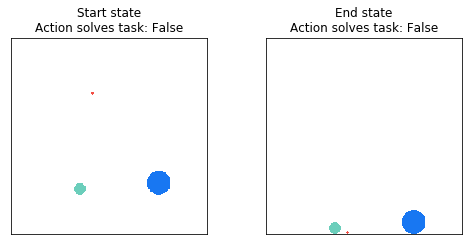

In [17]:
target_status = phyre.SimulationStatus.NOT_SOLVED if simulation.status == phyre.SimulationStatus.SOLVED else phyre.SimulationStatus.SOLVED
bad_action = actions[0]
simulation = simulator.simulate_action(task_index, bad_action, need_images=True)
assert simulation.status.is_not_solved()

# Get the start and end state of the simulation.
img_start = phyre.vis.observations_to_float_rgb(simulation.images[0])
img_end = phyre.vis.observations_to_float_rgb(simulation.images[-1])

# Visualize.
fig, axs = plt.subplots(1, 2, figsize=(7, 7))
fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axs[0].imshow(img_start)
axs[0].title.set_text(f'Start state\nAction solves task: {simulation.status.is_solved()}')
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])

axs[1].imshow(img_end)
axs[1].title.set_text(f'End state\nAction solves task: {simulation.status.is_solved()}')
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([]);


# Part 2: Random Agent
We now build our agent. We will build the simplest agent possible: an agent that each attempt makes a random (but valid) action.

In [18]:
# We define the evaluation of this agent on a given dataset split as follows:


def evaluate_random_agent(tasks, tier):
    """Evaluates the random agent on the given tasks/tier.

    Args:
        tasks: A list of task instances (strings) in the split to evaluate.
        tier: A string of the action tier.

    Returns:
        A Evaluator object updated with the results of all the siulations.
    """

    # Create a simulator for the task and tier.
    simulator = phyre.initialize_simulator(tasks, tier)
    evaluator = phyre.Evaluator(tasks)
    assert tuple(tasks) == simulator.task_ids
    for task_index in tqdm_notebook(range(len(tasks)), desc='Evaluate tasks'):
        while evaluator.get_attempts_for_task(
                task_index) < phyre.MAX_TEST_ATTEMPTS:
            # Sample a random valid action from the simulator for the given action space.
            action = simulator.sample()
            # Simulate the given action and add the status from taking the action to the evaluator.
            status = simulator.simulate_action(task_index,
                                                  action,
                                                  need_images=False).status
            evaluator.maybe_log_attempt(task_index, status)
    return evaluator

Let's evaluate our agent on the dev set (for performance).

In [19]:
# NOTE: Evaluating this agent can take ~1.5 minutes.
evaluator = evaluate_random_agent(tasks, action_tier)

The metric used to compare the performance of agents is AUCESS after 100 attempts. See the PHYRE paper for more details on the AUCESS metric.

In [20]:
print('AUCESS after 100 attempts of random agent on dev set',
      evaluator.get_aucess())

AUCESS after 100 attempts of random agent on dev set 0.5144086813306381
